## Prerequisites

This notebook requires numpy, tensorflow, keras, OpenCV and matplotlib libraries being installed on your machine. <br>
If executing without creating snapshot files beforehand, as described in <a href="https://github.com/lizaalert/lacmus/blob/master/docs/train-usage.md">train-usage.md</a>, compile Cython extentions first by running from the console:
```bash
python setup.py build_ext --inplace
```
Or see <a href="https://github.com/lizaalert/lacmus/blob/master/docs/train-usage.md#installation">Installation</a> section in the document above. <br>
Make sure the <b>'snapshots'</b> folder contains file with weights of pretrained model. For example, the <b>'resnet50_liza_alert_v1_interface.h5'</b> can be found here: <br>
<a href="https://github.com/lizaalert/lacmus/releases/tag/0.1.1">https://github.com/lizaalert/lacmus/releases/tag/0.1.1</a> <br>
(Pay attention to the file size!) <br><br>
Examples can be found here:<br>
<a href="https://github.com/lizaalert/lacmus/blob/master/docs/work-demo.md">https://github.com/lizaalert/lacmus/blob/master/docs/work-demo.md</a>


## Load necessary modules

In [ ]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# use this to change which GPU to use
gpu = 0

# set the modified tf session as backend in keras
setup_gpu(gpu)

## Load RetinaNet model

In [ ]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/lizaalert/lacmus/releases/tag/0.1.1
model_path = os.path.join('snapshots', 'resnet50_liza_alert_v1_interface.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
#look at: https://github.com/lacmus-foundation/lacmus/blob/master/docs/train-usage.md
#model = models.convert_model(model)


# load label to names mapping for visualization purposes
labels_to_names = {0: 'Pedestrian'}

## Run detection on example

In [13]:
sdd_images = os.listdir('examples/')
print(sdd_images)

['235.jpg']


In [14]:
def run_detection_image(filepath):
    image = read_image_bgr(filepath)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.5:
            break

        color = label_color(label)
        
        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)
        print("\nperson!\n")

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
    
    file, ext = os.path.splitext(filepath)
    image_name = file.split('/')[-1] + ext
    output_path = os.path.join('RetinaNet/examples/results/', image_name)
    
    draw_conv = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    cv2.imwrite(output_path, draw_conv)

processing time:  0.5668792724609375

person!



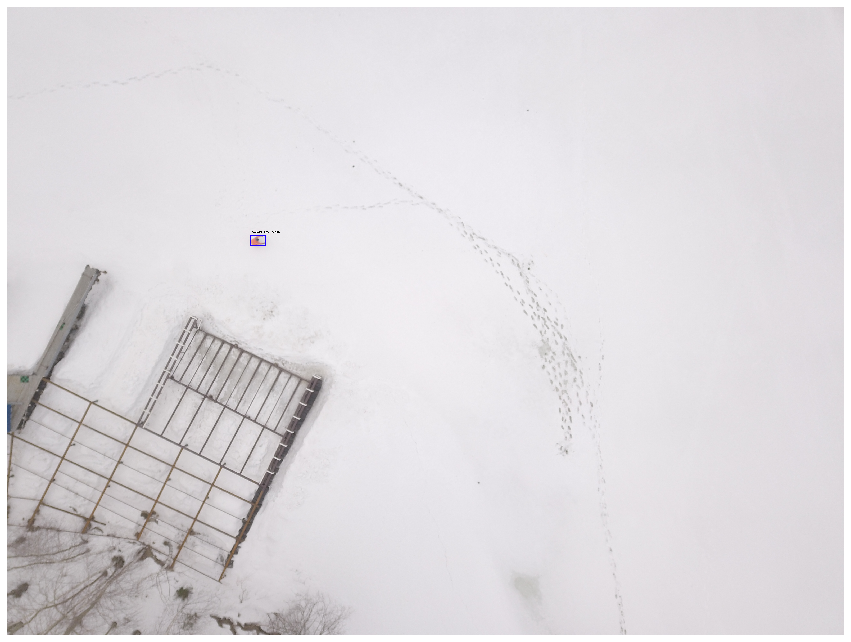

In [17]:
base_path = 'examples/'

for image in sdd_images:
    run_detection_image(os.path.join(base_path,image))